## Setup

In [1]:
!nvidia-smi

Wed Jun 11 18:13:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 PCIe               On  |   00000000:06:00.0 Off |                    0 |
| N/A   53C    P0             59W /  350W |       1MiB /  81559MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import torch
import bitsandbytes as bnb
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments
from peft import LoraConfig
from trl import SFTTrainer

## Prepare the dataset

In [3]:
import pandas as pd

train_path = 'data/hate_train.csv'

base_df = pd.read_csv(train_path)
base_df.head()

,sentence,label
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0
1,@anonymized_account @anonymized_account Brawo ...,0
2,"@anonymized_account @anonymized_account Super,...",0
3,@anonymized_account @anonymized_account Musi. ...,0
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0


Prepare prompt function

In [4]:
def make_prompt(text: str, label: int | None = None) -> int:
    prompt = f"""Jesteś modelem klasyfikującym pojedyncze polskie tweety. Zwróć cyfrę:
- 1, jeśli tekst zawiera bezpośrednie obelgi, dehumanizację lub mowę nienawiści (skierowaną do osób/grup; np. „jesteś idiotą”, „wszyscy oni to śmiecie”),
- 0, jeśli tekst jest neutralny, pytający, polityczny, przenośny lub opisuje zjawiska/obiekty bez ataku na człowieka.

Przykłady:
Tekst: "poseł Halicki oburzony za Bolka. Naprawdę taki tępy czy tylko udaje idiotę?"
Etykieta: 1

Tekst: "RT @anonymized_account Halicki: proszę nie mówić, że marnymi 15 mld można przykryć kilka milionów...😂😂😂"
Etykieta: 0

Tekst: "Chyba musimy się już do grobu pakować roczniku 98 😂👌🏻"
Etykieta: 0

Twoja kolej:
Tekst: "{text}"
Etykieta: """ + (str(label) if label is not None else "")

    return prompt.strip()

Prepare datasets

In [5]:
from datasets import Dataset
from sklearn.model_selection import train_test_split


def prepare_dataset(path, test_size=0.2, random_state=42):
    ds = pd.read_csv(path)
    ds = ds.rename(columns={'sentence': 'text'})

    train_df, val_df = train_test_split(ds, test_size=test_size, random_state=random_state, shuffle=True)
    
    train = Dataset.from_pandas(train_df.reset_index(drop=True))
    val = Dataset.from_pandas(val_df.reset_index(drop=True))

    def map_fn(row):
        return {
            "text":  make_prompt(row["text"], row["label"]),
            "raw": row["text"],
            "label": row["label"]
        }

    train = train.map(map_fn, remove_columns=["text", "label"])
    val = val.map(map_fn, remove_columns=["text", "label"])

    return train, val

train_ds, eval_ds = prepare_dataset(train_path)

print(f"Train dataset size: {len(train_ds)}")
print(f"Eval dataset size: {len(eval_ds)}")

Map:   0%|          | 0/8032 [00:00<?, ? examples/s]

Map:   0%|          | 0/2009 [00:00<?, ? examples/s]

Train dataset size: 8032
Eval dataset size: 2009


In [6]:
train_ds[0], eval_ds[0]

({'text': 'Jesteś modelem klasyfikującym pojedyncze polskie tweety. Zwróć cyfrę:\n- 1, jeśli tekst zawiera bezpośrednie obelgi, dehumanizację lub mowę nienawiści (skierowaną do osób/grup; np. „jesteś idiotą”, „wszyscy oni to śmiecie”),\n- 0, jeśli tekst jest neutralny, pytający, polityczny, przenośny lub opisuje zjawiska/obiekty bez ataku na człowieka.\n\nPrzykłady:\nTekst: "poseł Halicki oburzony za Bolka. Naprawdę taki tępy czy tylko udaje idiotę?"\nEtykieta: 1\n\nTekst: "RT @anonymized_account Halicki: proszę nie mówić, że marnymi 15 mld można przykryć kilka milionów...😂😂😂"\nEtykieta: 0\n\nTekst: "Chyba musimy się już do grobu pakować roczniku 98 😂👌🏻"\nEtykieta: 0\n\nTwoja kolej:\nTekst: "Dzisiaj brat przyjeżdża z dziećmi na obiad wiec zrobię zupę pieczarkową a na drugie powiem tacie żeby kupił pierogi"\nEtykieta: 0',
  'label': 0,
  'raw': 'Dzisiaj brat przyjeżdża z dziećmi na obiad wiec zrobię zupę pieczarkową a na drugie powiem tacie żeby kupił pierogi'},
 {'text': 'Jesteś modele

## Fine tune model

In [13]:
model_name = "speakleash/Bielik-7B-Instruct-v0.1"

bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16,
)
model.config.use_cache = False

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Determine the needed context length

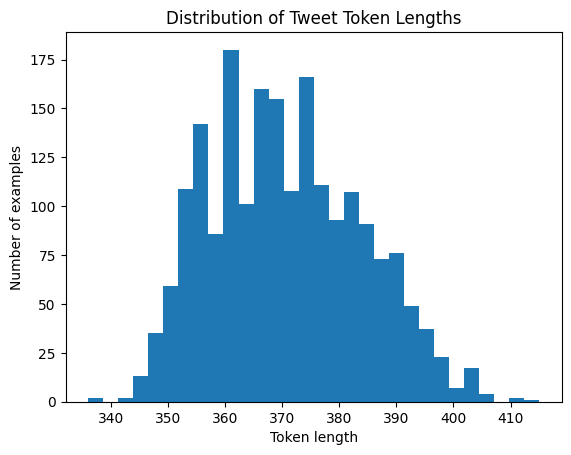

In [10]:
import matplotlib.pyplot as plt

texts = [ex["text"] for ex in eval_ds]
lengths = [len(tokenizer(text, truncation=False)["input_ids"]) for text in texts]

plt.figure()
plt.hist(lengths, bins=30)
plt.xlabel("Token length")
plt.ylabel("Number of examples")
plt.title("Distribution of Tweet Token Lengths")
plt.show()

Tokenize the dataset

In [11]:
def tokenize_fn(ex):
    return tokenizer(
        ex["text"],
        truncation=True,
        max_length=512,
        padding="max_length",
    )

tokenized_train_ds = train_ds.map(
    tokenize_fn,
    batched=False,
    remove_columns=["text", "raw"],
)
tokenized_eval_ds = eval_ds.map(
    tokenize_fn,
    batched=False,
    remove_columns=["text", "raw"],
)

Map:   0%|          | 0/8032 [00:00<?, ? examples/s]

Map:   0%|          | 0/2009 [00:00<?, ? examples/s]

In [14]:
output_dir = "bielik-hate-speech"
epochs = 1
batch_size = 8

target_modules = [
    name for name, module in model.named_modules()
    if isinstance(module, bnb.nn.Linear4bit)
]

peft_config = LoraConfig(
    task_type="CAUSAL_LM",
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
)

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    learning_rate=2e-5,
    optim="paged_adamw_32bit",
    fp16=True,
    eval_strategy="steps",
    eval_steps=25,
    logging_steps=25,
    save_total_limit=2,
)

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_eval_ds,
    peft_config=peft_config
)
trainer.train()
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Fine-tuning complete! Model saved to {output_dir}")

Truncating train dataset:   0%|          | 0/8032 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/2009 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/home/ubuntu/ssne/.venv/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss,Validation Loss
25,2.144000,1.661550
50,1.424900,1.157212
75,0.848100,0.537793
100,0.376600,0.277109
125,0.241800,0.222371
150,0.211000,0.202350
175,0.190900,0.193003
200,0.193600,0.189642
225,0.192600,0.188342
250,0.188100,0.187750


Fine-tuning complete! Model saved to bielik-hate-speech


## Evaluation

Generate predictions for the evaluation set

In [16]:
from tqdm import tqdm

BATCH_SIZE = 16

texts   = [ex["raw"] for ex in eval_ds]
prompts = [make_prompt(t) for t in texts]

model.eval()
device = model.device

y_pred = []
with torch.no_grad():
    for i in tqdm(range(0, len(prompts), BATCH_SIZE)):
        chunk = prompts[i : i + BATCH_SIZE]
        enc = tokenizer(chunk, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

        outs = model.generate(
            **enc,
            max_new_tokens=4,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
        )

        decoded = tokenizer.batch_decode(outs, skip_special_tokens=True)
        for dec, prom in zip(decoded, chunk):
            gen = dec[len(prom):].strip()
            y_pred.append(int(gen[0]) if gen and gen[0] in ("0","1") else 0)

        torch.cuda.empty_cache()

y_true = [int(ex["label"]) for ex in eval_ds]

  0%|          | 0/126 [00:00<?, ?it/s]

/home/ubuntu/ssne/.venv/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
100%|██████████| 126/126 [04:57<00:00,  2.36s/it]


Print the classification report

In [17]:
from sklearn.metrics import classification_report

cr = classification_report(y_true, y_pred, target_names=["non-hate","hate"], digits=4)
print(cr)

              precision    recall  f1-score   support

    non-hate     0.9385    0.8951    0.9163      1840
        hate     0.2402    0.3609    0.2884       169

    accuracy                         0.8502      2009
   macro avg     0.5893    0.6280    0.6023      2009
weighted avg     0.8797    0.8502    0.8635      2009



Plot the confusion matrix

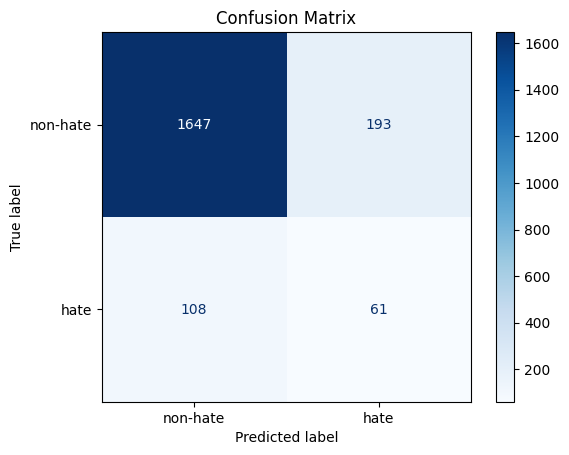

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["non-hate", "hate"])
disp.plot(ax=ax, cmap=plt.cm.Blues)
ax.set_title("Confusion Matrix")
plt.show()

Print examples of misclassified samples

In [19]:
count = 0
for text, true, pred in zip(texts, y_true, y_pred):
    if true != pred:
        count += 1
        print(f"Example {count}")
        print("Text:      ", text)
        print("Predicted: ", pred)
        print("True:      ", true)
        print("-" * 60)
        if count >= 10:
            break

Example 1
Text:       @anonymized_account @anonymized_account Czyli tylko dlatego nie napiszesz o konkretach 😂 dziękujemy łaskawco inaczej bylibyśmy już pogrążeni
Predicted:  0
True:       1
------------------------------------------------------------
Example 2
Text:       @anonymized_account Urban powinien się od was uczyć. Jesteście żenujące gnojki. Aż przykro patrzeć.
Predicted:  0
True:       1
------------------------------------------------------------
Example 3
Text:       @anonymized_account A ile razy więcej niż na miesięcznicy?\n\nKretyńskie porównania...
Predicted:  1
True:       0
------------------------------------------------------------
Example 4
Text:       @anonymized_account @anonymized_account @anonymized_account Uważaj, bo zaraz się Tobą zajmę i na pewno się coś znajdzie! :)
Predicted:  1
True:       0
------------------------------------------------------------
Example 5
Text:       @anonymized_account hehe niech uważa bo jeszcze ktoś uwierzy że będzie stawiał na 